In [1]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# Итак, к данному этапу Вы из массива изображений "восстановили" текст.
# Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
# Рассчитайте метрику CER.




In [2]:
COUNT_NUMBERS_IN_STRINGS = 10
COUNT_STRINGS = 10

import os
import random

directory = 'data'
symbols = list(map(lambda x: x.replace('times', '*'), [sym for sym in os.listdir(directory)]))
strings = [''.join(random.choices(symbols, k = COUNT_NUMBERS_IN_STRINGS)) for _ in range(COUNT_STRINGS)]

print(f'Возможные символы: {symbols}\nСтроки: {strings}')

Возможные символы: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', '*', 'w', 'X', 'y']
Строки: [',84721,26t', '*40h)4y3w)', '1hh4wy7X6*', '5t(7h+2X56', 'h2h-t93hyy', '99h54w3ty)', '5294(y+602', '0*-yw86X+*', 'w),,wXwh34', 'h6X727-6y1']


In [3]:
from PIL import Image

def combine_images_to_string(images, max_offset=50, spacing=5):

    scaled_images = [
        Image.open(img).resize(
            (int(Image.open(img).width * scale), int(Image.open(img).height * scale)),
            Image.LANCZOS
        )
        for img, scale in zip(images, [random.uniform(0.8, 0.9) for _ in images])
    ]

    total_width = sum(img.width for img in scaled_images) + spacing * (len(scaled_images) - 1)
    max_height = max(img.height for img in scaled_images) + max_offset
    combined_image = Image.new('RGB', (total_width, max_height), (255, 255, 255))

    x_offset = 0
    for img in scaled_images:
        combined_image.paste(img, (x_offset, random.randint(0, max_offset)))
        x_offset += img.width + spacing

    return combined_image


In [4]:
def get_sym_images_paths_map():
    symb_images = {}
    for sym in symbols:
        folder = directory + '/' + (sym if sym != '*' else 'times')
        symb_images[sym] = [folder + '/' + img_path for img_path in os.listdir(folder)]
    return symb_images

In [5]:

def get_string_images_paths_map(sym_images):
    return {string : [sym_images[symbol][random.randint(0, len(sym_images[symbol]) - 1)] for symbol in string] for string in strings}

In [6]:
from glob import glob

sym_images = get_sym_images_paths_map()
strings_images = get_string_images_paths_map(sym_images)

my_images_directory = 'images'
[os.remove(file) for file in glob(f'{my_images_directory}/*')]

my_images_paths = {}

for i, (string, images) in enumerate(strings_images.items(), start=1):
    new_image = combine_images_to_string(images)
    path = f'{my_images_directory}/{i}.png'
    new_image.save(path)
    my_images_paths[string] = path

In [13]:
import cv2
import numpy as np

def get_cv_image(image):
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    return image

def get_vector(image):
    image = get_cv_image(image)

    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        return cv2.resize(image[y:y+h, x:x+w], (28, 28)).flatten()

    return np.zeros((28 * 28,))


from concurrent.futures import ThreadPoolExecutor

def prepare_data(data_dict):
    X = []
    y = []
    def process_label_images(label, img_paths):
        vectors = [get_vector(path) for path in img_paths]
        labels = [label] * len(vectors)
        return vectors, labels

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda item: process_label_images(*item), data_dict.items()))

    for vectors, labels in results:
        X.extend(vectors)
        y.extend(labels)

    return np.array(X), np.array(y)

In [14]:
from sklearn.model_selection import train_test_split

X, y = prepare_data(sym_images)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def find_optimal_k(X_train, y_train, k_range=(1, 5)):
    param_grid = {'n_neighbors': list(range(k_range[0], k_range[1] + 1))}
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_['n_neighbors']

optimal_k = 1 # опытным путем

print(f'optimal_k = {optimal_k}')

optimal_k = 1


In [16]:
from sklearn.metrics import accuracy_score

knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train, y_train)
predictions = knn_model.predict(X_test)

print(f'accuracy = {accuracy_score(y_test, predictions)}')

accuracy = 0.9944073326083579


In [17]:
import matplotlib.pyplot as plt

def merge_two_rects(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    x = min(x1, x2)
    y = min(y1, y2)
    w = max(x1 + w1, x2 + w2) - x
    h = max(y1 + h1, y2 + h2) - y
    return (x, y, w, h)

def calculate_distance(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    center1 = (x1 + w1 / 2, y1 + h1 / 2)
    center2 = (x2 + w2 / 2, y2 + h2 / 2)
    return ((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2) ** 0.5

def merge_close_rectangles(rects, distance_threshold, count_limit):
    while len(rects) > count_limit:
        pairs_to_merge = [
            (rects[i], rects[j]) 
            for i in range(len(rects)) 
            for j in range(i + 1, len(rects))
            if calculate_distance(rects[i], rects[j]) < distance_threshold
        ]

        if not pairs_to_merge: break  # Если нет пар для объединения, выходим из цикла

        rect1, rect2 = pairs_to_merge[0]
        merged_rect = merge_two_rects(rect1, rect2)
        rects.remove(rect1)
        rects.remove(rect2)
        rects.append(merged_rect)

    return rects

def merge_rectangles(rects, distance_threshold = 25, count_limit = COUNT_NUMBERS_IN_STRINGS):
    rects = merge_close_rectangles(rects, distance_threshold, count_limit)
    
    if len(rects) > count_limit:
        rects = sorted(rects, key=lambda rect: (rect[2] * rect[3]), reverse=True)
        big_rects = rects[:count_limit]
        other_rects = rects[count_limit:]

        for rect in other_rects:
            closest_big_rect = min(big_rects, key=lambda big: calculate_distance(rect, big))
            merged_rect = merge_two_rects(rect, closest_big_rect)
            big_rects[big_rects.index(closest_big_rect)] = merged_rect

        return big_rects

    return rects

def extract_symbols(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)[1]
    dilated = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
    rects = [cv2.boundingRect(c) for c in cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]

    if len(rects) > COUNT_NUMBERS_IN_STRINGS:
        rects = merge_rectangles(rects)

    rects.sort(key=lambda r: r[0])

    symbols = [get_vector(image[y:y+h, x:x+w]) for (x, y, w, h) in rects]

    for (x, y, w, h) in rects:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    return symbols

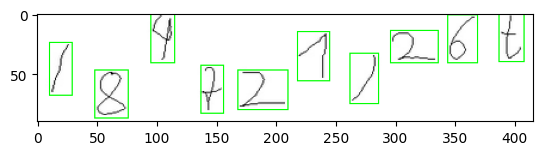

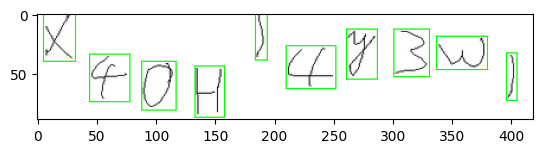

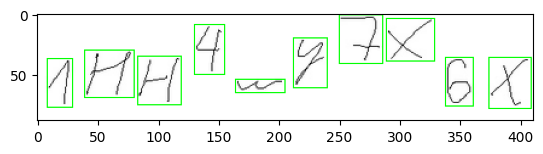

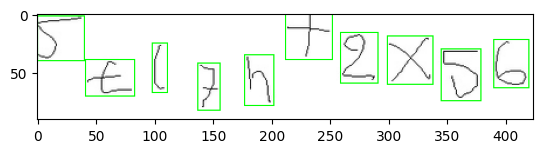

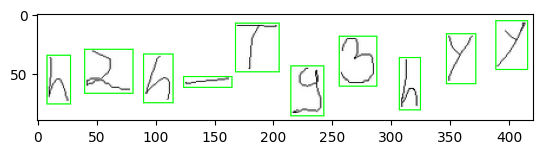

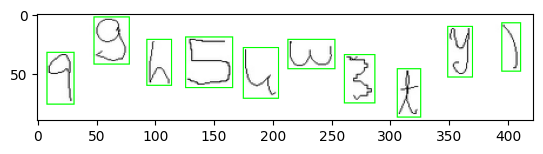

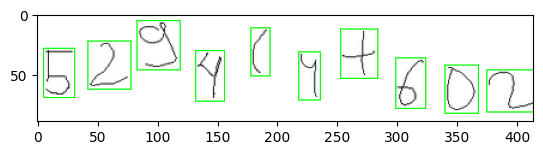

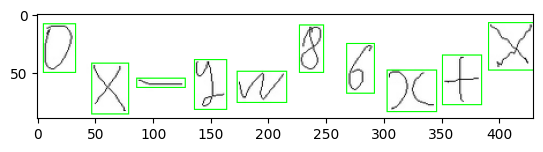

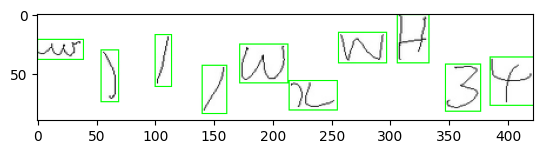

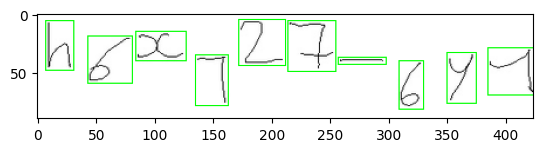

In [18]:
results = []
symb_vectors = []

for string, img_path in my_images_paths.items():
    symb_images = extract_symbols(img_path)
    if len(symb_images) == COUNT_NUMBERS_IN_STRINGS:
        predictions = knn_model.predict(symb_images)
        accuracy = accuracy_score(list(string), predictions)
        results.append((list(string), predictions, accuracy))
    else:
        print('Неправильно определены контуры')

In [20]:
from pandas import DataFrame, concat

df_results = DataFrame(results, columns=['Исходные символы', 'Предсказанные символы', 'Accuracy'])
mean_accuracy = df_results['Accuracy'].mean()

new_row = DataFrame({
    'Исходные символы': [''],
    'Предсказанные символы': ['Средняя accuracy'],
    'Accuracy': [mean_accuracy]
})

df_result = concat([df_results, new_row], ignore_index=True)
df_result

,Исходные символы,Предсказанные символы,Accuracy
0,"[,, 8, 4, 7, 2, 1, ,, 2, 6, t]","[,, *, 4, 2, X, 1, ), X, 6, 1]",0.40
1,"[*, 4, 0, h, ), 4, y, 3, w, )]","[-, 2, ), 4, 1, 4, y, +, ), 1]",0.20
2,"[1, h, h, 4, w, y, 7, X, 6, *]","[1, h, 1, 4, w, -, 7, y, 6, -]",0.60
3,"[5, t, (, 7, h, +, 2, X, 5, 6]","[5, t, 0, ,, h, +, X, -, 5, 6]",0.60
4,"[h, 2, h, -, t, 9, 3, h, y, y]","[h, +, ,, -, 1, 1, 3, -, y, 4]",0.40
5,"[9, 9, h, 5, 4, w, 3, t, y, )]","[9, 1, 1, 5, 4, 1, ), t, 1, )]",0.50
6,"[5, 2, 9, 4, (, y, +, 6, 0, 2]","[5, ,, 1, 4, (, 4, 1, X, t, -]",0.30
7,"[0, *, -, y, w, 8, 6, X, +, *]","[0, *, -, y, 1, 8, 6, X, +, *]",0.90
8,"[w, ), ,, ,, w, X, w, h, 3, 4]","[1, -, ,, t, t, X, t, 1, 4, 4]",0.30
9,"[h, 6, X, 7, 2, 7, -, 6, y, 1]","[h, (, X, 1, 2, 7, -, (, ,, 1]",0.60


In [25]:
import editdistance

def modify_and_calculate_cer(row):
    original = list(row['Исходные символы'])
    predicted = list(row['Предсказанные символы'])

    num_to_modify = random.randint(1, 3)
    indices = random.sample(range(len(predicted)), num_to_modify)
    predicted = [predicted[i] for i in range(len(predicted)) if i not in indices]
    predicted += random.choices(symbols, k=num_to_modify)

    cer = editdistance.eval(''.join(original), ''.join(predicted)) / max(len(original), len(predicted) or 1)
    return ''.join(original), ''.join(predicted), cer

In [27]:
df_results[['Исходные символы', 'Предсказанные символы', 'CER']] = df_results.apply(modify_and_calculate_cer, axis=1, result_type='expand')

mean_cer = df_results['CER'].mean()

new_row = DataFrame({
    'Исходные символы': [''],
    'Предсказанные символы': ['Среднее значение'],
    'CER': [mean_cer]
})

df_сer = concat([df_results, new_row], ignore_index=True).drop(columns=['Accuracy'])
df_сer

,Исходные символы,Предсказанные символы,CER
0,",84721,26t",",*2X1)X14t",0.80
1,*40h)4y3w),-24y+)1*56,0.90
2,1hh4wy7X6*,"1w-76-087,",0.90
3,5t(7h+2X56,50+-56)-61,0.90
4,h2h-t93hyy,"+11-4),29)",0.90
5,99h54w3ty),"1541t1,,-*",1.00
6,5294(y+602,"5,14(4t-8X",0.70
7,0*-yw86X+*,0y16X+*9)8,0.70
8,"w),,wXwh34","1-,t41(387",0.90
9,h6X727-6y1,"h(X7-,1,+8",0.70
